In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from functools import partial

In [2]:
import os
os.sys.path.append('/Users/yuanqingwang/Documents/GitHub/lean')

In [3]:
def potential_component(
        x, 
        tao=1.0, 
        a=0.0, 
        b=-4.0, 
        c=0.9, 
        d0=4.0,
        **kwargs,
):
    energy = (1 / (2 * tao)) * (
        a * (x - d0)
        + b * (x - d0) ** 2
        + c * (x - d0) ** 4
    )
    return energy


def potential(
        x,
        **kwargs,
):
    return potential_component(x, **kwargs).sum()

kinetic = lambda p: 0.5 * (p ** 2).sum()

In [4]:
def time_dependent_potential_component(
        x, 
        tao=1.0, 
        a=0.0, 
        b=-4.0, 
        c=0.9, 
        d0=4.0,
        time=0.0,
        a_coefficient_sin=0.5,
        b_coefficient_sin=0.5,
        c_coefficient_sin=0.5,
        a_coefficient_cos=0.5,
        b_coefficient_cos=0.5,
        c_coefficient_cos=0.5,
):
    energy = (1 / (2 * tao)) * (
        a * (x - d0)
        + b * (x - d0) ** 2
        + c * (x - d0) ** 4
    )

    a_term = a * (x - d0)
    b_term = b * (x - d0) ** 2
    c_term = c * (x - d0) ** 4

    a_term = a_term * (a_coefficient_sin * jnp.sin(time) + a_coefficient_cos * jnp.cos(time))
    b_term = b_term * (b_coefficient_sin * jnp.sin(time) + b_coefficient_cos * jnp.cos(time))
    c_term = c_term * (c_coefficient_sin * jnp.sin(time) + c_coefficient_cos * jnp.cos(time))

    energy = (1 / (2 * tao)) * (
        a_term
        + b_term
        + c_term
    )

    return energy

def time_dependent_potential(
        x,
        **kwargs,
):
    return time_dependent_potential_component(x, **kwargs).sum()

In [5]:
from lean.samplers import HamiltonianMonteCarlo
a_coefficient_sin = 0.5
b_coefficient_sin = 0.5
c_coefficient_sin = 0.5
a_coefficient_cos = 0.5
b_coefficient_cos = 0.5
c_coefficient_cos = 0.5

def loss(
        a_coefficient_sin=0.5,
        b_coefficient_sin=0.5,
        c_coefficient_sin=0.5,
        a_coefficient_cos=0.5,
        b_coefficient_cos=0.5,
        c_coefficient_cos=0.5,
        seed=2666,
        num_samples=100,
):
        key = jax.random.PRNGKey(seed)
        key, subkey = jax.random.split(key)
        position = jax.random.uniform(subkey, shape=(num_samples,), minval=2, maxval=6)
        momentum = jax.random.normal(subkey, shape=(num_samples,))
        _time_dependent_potential = partial(
                time_dependent_potential,
                a_coefficient_sin=a_coefficient_sin, 
                b_coefficient_sin=b_coefficient_sin, 
                c_coefficient_sin=c_coefficient_sin, 
                a_coefficient_cos=a_coefficient_cos, 
                b_coefficient_cos=b_coefficient_cos, 
                c_coefficient_cos=c_coefficient_cos,
        )
        sampler = HamiltonianMonteCarlo(_time_dependent_potential, kinetic, 0.1, 100)
        position, momentum = sampler(position, momentum)
        energy = potential(position) + (position ** 2).sum()
        return energy


In [6]:
import optax
optimizer = optax.adam(1e-3)
params = {
    'a_coefficient_sin': 0.5,
    'b_coefficient_sin': 0.5,
    'c_coefficient_sin': 0.5,
    'a_coefficient_cos': 0.5,
    'b_coefficient_cos': 0.5,
    'c_coefficient_cos': 0.5,
}

opt_state = optimizer.init(params)
loss_fn = lambda params: loss(**params)
for _ in range(1000):
    energy, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    print(energy)

1668.637
1663.8507
1660.0193
1656.4108
1652.5394
1648.0901
1643.5222
1640.5205
1637.0135
1642.2985
1644.1594
1644.9728
1645.7964
1646.5717
1646.407
1645.4553
1644.1389
1642.5251
1641.0867
1644.7219
1647.0972
1649.3326
1651.1351
1652.3936
1653.2131
1653.7422
1654.0491
1654.153
1654.0503
1653.7686
1653.3368
1652.7529
1651.9949
1651.0159
1649.7731
1648.2949
1646.6785
1645.048
1643.51
1642.4564
1641.4961
1640.36
1637.8654
1634.8469
1633.4375
1634.1047
1635.0864
1635.7006
1636.0315
1636.2028
1636.2837
1636.2997
1636.2582
1636.1626
1636.0157
1635.8218
1635.5864
1635.3124
1635.0094
1634.6763
1634.3098
1633.897
1633.4167
1632.8331
1632.1014
1631.2155
1630.3533
1629.9526
1630.2341
1630.6602
1630.6084
1629.9664
1629.0963
1628.5322
1628.3926
1628.4128
1628.3596
1628.1486
1627.7792
1627.2854
1626.7479
1626.301
1626.0524
1625.92
1625.6913
1625.2648
1624.7512
1624.3152
1623.9984
1623.7202
1623.3976
1622.9939
1622.5292
1622.0515
1621.62
1621.2443
1620.8649
1620.4204
1619.9186
1619.4216
1618.9584
1618

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1052df2f0>>
Traceback (most recent call last):
  File "/Users/yuanqingwang/miniconda3/envs/mudslide/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


1454.2991
1453.2599
1452.8196
1452.6029
1451.3363
1459.221
1451.4519
1455.0366
1458.2261
1459.8539
1460.0693
1458.9598
1456.7827
1453.5846
1449.7904
1448.7646
1468.5995
1451.3441
1450.6238
1457.0354
1462.3312
1468.4342
1465.838
1460.6655
1456.803
1452.8939
1448.2338
1446.6809
1463.9849
1445.0049
1461.6522
1452.4585
1482.8667
1483.1023
1459.7458
1458.1501
1463.532
1466.7919


In [7]:
from turtle import pos
seed = 2666
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
num_samples = 100
_time_dependent_potential = partial(
        time_dependent_potential,
        **params,
)
position = jax.random.uniform(subkey, shape=(num_samples,), minval=2, maxval=6)
momentum = jax.random.normal(subkey, shape=(num_samples,))
sampler = HamiltonianMonteCarlo(_time_dependent_potential, kinetic, 0.01, 1000)
position, momentum = sampler(position, momentum)

<Axes: ylabel='Density'>

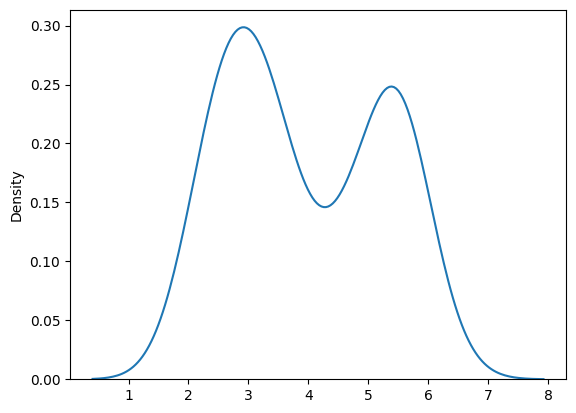

In [8]:
import seaborn as sns
sns.kdeplot(position)